In [108]:
import deepchem as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics 
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix as cm_sklearn

from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*') 

#### Prepare dataset

In [3]:
# Load HIV dataset
hiv_tasks, datasets, transformers = dc.molnet.load_hiv(featurizer="ECFP", set="sparse", splitter = dc.splits.RandomStratifiedSplitter())

In [4]:
# Split 80/10/10
train_dataset, valid_dataset, test_dataset = datasets
print(f'Compound train/valid/test split: {len(train_dataset)}/{len(valid_dataset)}/{len(test_dataset)}')

Compound train/valid/test split: 32902/4113/4112


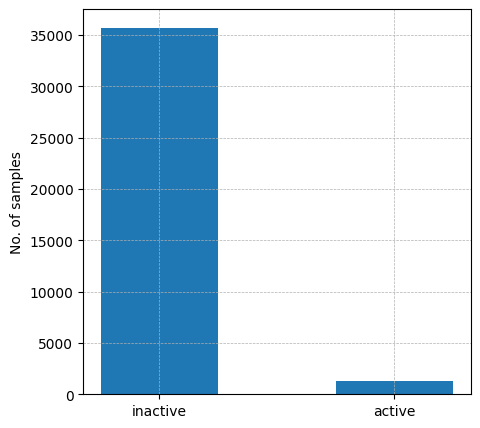

In [5]:
num_0 = list([int(l) for l in train_dataset.y]).count(0) + list([int(l) for l in test_dataset.y]).count(0)
num_1 = list([int(l) for l in train_dataset.y]).count(1) + list([int(l) for l in test_dataset.y]).count(1)

fig = plt.figure(figsize = (5, 5))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.bar(['inactive', 'active'], [num_0, num_1], width = 0.5)
plt.ylabel("No. of samples")
plt.show()

In [6]:
df_test = pd.DataFrame(test_dataset.X)
df_test['label'] = list([int(l) for l in test_dataset.y])
x_test = df_test.drop('label', axis=1)
y_test = df_test['label']

df_train = pd.DataFrame(train_dataset.X)
df_train['label'] = list([int(l) for l in train_dataset.y])
x_train = df_train.drop('label', axis=1)
y_train = df_train['label']

#### Train RF model

In [7]:
def plot_discrimination_threshold(clf, X_test, y_test, argmax='f1', title='Metrics vs Discriminant Threshold', fig_size=(7, 5), dpi=100, save_fig_path=None):
        
    thresholds = np.linspace(0, 1, 100)   
    precision_ls, recall_ls, f1_ls, fpr_ls, fnr_ls = [], [], [], [], []
    probs = clf.predict_proba(X_test)[:,1]

    for threshold in thresholds:   
        y_predictions = np.where(probs>=threshold, 1, 0) 
        tn, fp, fn, tp = cm_sklearn(y_test, y_predictions).ravel()
        FPR = fp / (tn + fp)
        FNR = fn / (tp + fn)
        precision = precision_score(y_test, y_predictions, average='binary')
        recall = recall_score(y_test, y_predictions, average='binary')
        f1 = f1_score(y_test, y_predictions, average='binary')
        precision_ls.append(precision)
        recall_ls.append(recall)
        f1_ls.append(f1)
        fpr_ls.append(FPR)
        fnr_ls.append(FNR)
              
    metrics = pd.concat([
        pd.Series(precision_ls),
        pd.Series(recall_ls),
        pd.Series(f1_ls),
        pd.Series(fpr_ls),
        pd.Series(fnr_ls)], axis=1)

    metrics.columns = ['precision', 'recall', 'f1', 'fpr', 'fnr']
    metrics.index = thresholds
    
    plt.rcParams["figure.facecolor"] = 'white'
    plt.rcParams["axes.facecolor"] = 'white'
    plt.rcParams["savefig.facecolor"] = 'white'
                
    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
    ax.plot(metrics['precision'], label='Precision')
    ax.plot(metrics['recall'], label='Recall')
    ax.plot(metrics['f1'], label='f1')
    ax.plot(metrics['fpr'], label='False Positive Rate (FPR)', linestyle='dotted')
    ax.plot(metrics['fnr'], label='False Negative Rate (FNR)', linestyle='dotted')
    
    disc_threshold = round(metrics[argmax].idxmax(), 2)
    ax.axvline(x=metrics[argmax].idxmax(), color='black', linestyle='dashed', label="$t_r$="+str(disc_threshold))   
    ax.legend(loc='best', frameon=True, framealpha=0.5)
    plt.grid(True)
    plt.xlabel('Probability Threshold', fontsize=10)
    plt.ylabel('Scores', fontsize=10)
    plt.show()

    return fig, ax, disc_threshold

In [8]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model f1 score : {0:0.4f}'. format(f1_score(y_test, y_pred, average='macro')))

Model accuracy score : 0.9706
Model f1 score : 0.7084


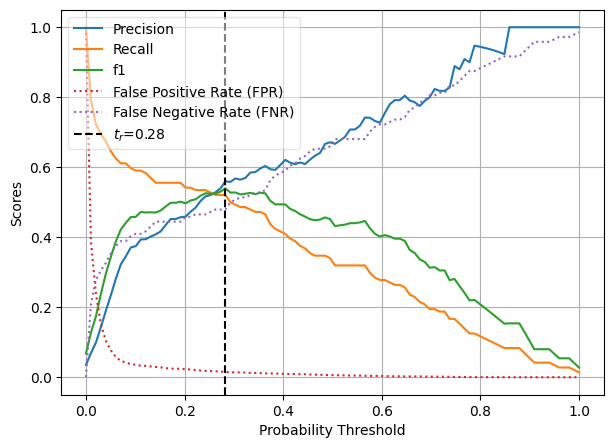

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='Probability Threshold', ylabel='Scores'>,
 0.28)

In [9]:
plot_discrimination_threshold(rfc, x_test, y_test)

In [10]:
threshold = 0.28

predicted_proba = rfc.predict_proba(x_test)
y_pred_threshold = (predicted_proba[:,1] >= threshold).astype('int')

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred_threshold)))
print('Model f1 score : {0:0.4f}'. format(f1_score(y_test, y_pred_threshold, average='macro')))

Model accuracy score : 0.9677
Model f1 score : 0.7566


#### Predict HIV activity for generated molecules

In [19]:
def check_validity(path):
    dfs_valid, percents = [], []
    for i in range(5):
        path_next = path + f'_{i}.csv'
        df = pd.read_csv(path_next)
        df_valid = pd.DataFrame(columns=['SMILES'])
        for smile in df['SMILES']:
            if Chem.MolFromSmiles(smile):
                df_valid.loc[len(df_valid.index)] = [smile]
        dfs_valid.append(df_valid)
        percents.append(len(df_valid)/len(df) * 100)
    return dfs_valid, statistics.mean(percents), statistics.stdev(percents)

In [21]:
dfs_valid, percents, dev = check_validity('generated_molecules/vae/vae_epoch20')

,SMILES
0,O=C(NC(CSCc1ccccc1)CC1(CC=Cc2ccccc2)c2ccccc2)C1=S
1,O=c1ccn(C2CCCCC2)c(=O)[nH]1
2,COc1ccc(N=C(NCc2ccccc2)c2ccccc2)c(O)c1
3,Cc1cc(Cl)c(O)cc1C(=O)O
4,CCC(C(C)C)=C(C#N)NC(C)C(C)CCCC(C)C=CC(=O)NCCc1...
...,...
457,CCOC(=O)C(=Cc1ccccc1)C(=O)Nc1ccccc1
458,CC(C)(C)C[PH](c1ccccc1)(c1ccccc1)c1ccccc1.O=C(...
459,CC(C)(C)OC(=O)NC(Cc1ccc2ccccc2c1)C(=O)N1CCCC1C...
460,NC(=S)NN=C(c1ccc(Cl)cc1)SCSC(=Cc1cccc(S(N)(=O)...


In [22]:
def check_hiv(dfs, clf):
    dfs_active, percents = [], []
    for df in dfs:    
        df_features = pd.DataFrame(columns=[str(i) for i in range(1024)])
        featurizer = dc.feat.CircularFingerprint(size=1024, radius=4)

        for smile in df['SMILES']:
            if len(featurizer.featurize(smile)[0]) == 1024:
                df_features.loc[len(df_features.index)] = list(featurizer.featurize(smile)[0])

        threshold = 0.28
        predicted_proba = clf.predict_proba(df_features)
        y_pred_threshold = (predicted_proba[:,1] >= threshold).astype('int')
        df['label'] = y_pred_threshold
        dfs_active.append(df)
        percents.append(list(df['label']).count(1)/len(df) * 100)
    return dfs_active, statistics.mean(percents), statistics.stdev(percents)

In [24]:
def count__valid_and_active(path, clf):
    dfs, valid, v_dev = check_validity(path)
    dfs_predict, active, a_dev = check_hiv(dfs, clf)
    return dfs_predict, valid, v_dev, active, a_dev

In [46]:
def plot_results(y, x_vae, vae_dev, x_cvae, cvae_dev, lim):
    fig = plt.figure(figsize = (5, 5))
    plt.plot(y, x_vae, color = 'blue',
         linestyle = 'solid', marker = 'o',
         markerfacecolor = 'white', markersize = 6, label="VAE")
    plt.errorbar(y, x_vae, yerr=vae_dev, fmt='--', ecolor='blue', capsize=3)
    plt.plot(y, x_cvae, color = 'orange',
         linestyle = 'solid', marker = 'o',
         markerfacecolor = 'white', markersize = 6, label="CVAE")
    plt.errorbar(y, x_cvae, yerr=cvae_dev, fmt='--', ecolor='orange', capsize=3)
    plt.ylabel("% of samples")
    plt.xlabel("Epoch")
    plt.ylim(0, lim)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='best', frameon=True, framealpha=0.5)
    plt.show()

In [52]:
def plot_info(model, clf):
    epochs = [20, 50, 100]
    x_valid, x_valid_dev, x_active, x_active_dev = [], [], [], []
    for epoch in epochs:
        dfs, valid, valid_dev, active, active_dev = count__valid_and_active(f'generated_molecules/{model}/{model}_epoch{epoch}', clf)
        x_valid.append(valid)
        x_valid_dev.append(valid_dev)
        x_active.append(active)
        x_active_dev.append(active_dev)
    return dfs[0], x_valid, x_valid_dev, x_active, x_active_dev


In [ ]:
df_vae, x_vae_valid, x_vae_valid_dev, x_vae_active, x_vae_active_dev = plot_info('vae', rfc)
df_cvae, x_cvae_valid, x_cvae_valid_dev, x_cvae_active, x_cvae_active_dev = plot_info('cvae', rfc)

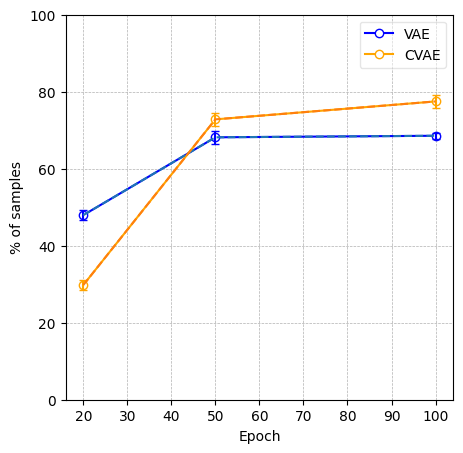

In [47]:
y_plot = [20, 50, 100] 
plot_results(y_plot, x_vae_valid, x_vae_valid_dev, x_cvae_valid, x_cvae_valid_dev, 100)

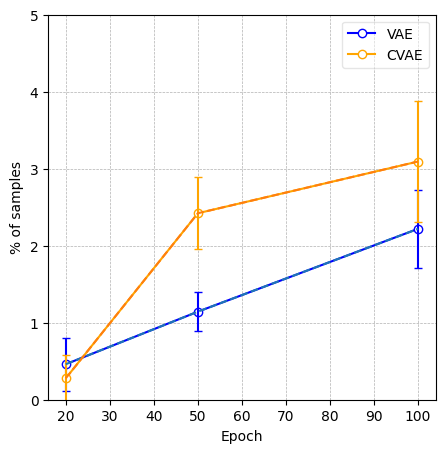

In [48]:
plot_results(y_plot, x_vae_active, x_vae_active_dev, x_cvae_active, x_cvae_active_dev, 5)

#### Exampels of generated molecules

In [100]:
def get_mols(df, label):
    mols = []
    for index, row in df.iterrows():
        if len(mols) == 6:
            break
        if row['label'] == label:
            mol = Chem.MolFromSmiles(row['SMILES'])
            mols.append(mol)
    return mols

In [101]:
mols_vae_0 = get_mols(df_vae, 0)
mols_vae_1 = get_mols(df_vae, 1)

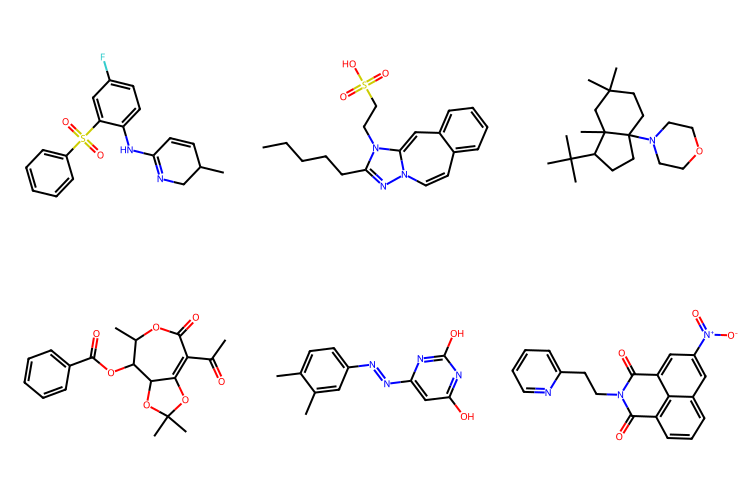

In [112]:
# VAE (INACTIVE)
MolsToGridImage(mols=mols_vae_0, molsPerRow=3, subImgSize=(250, 250), useSVG=True)

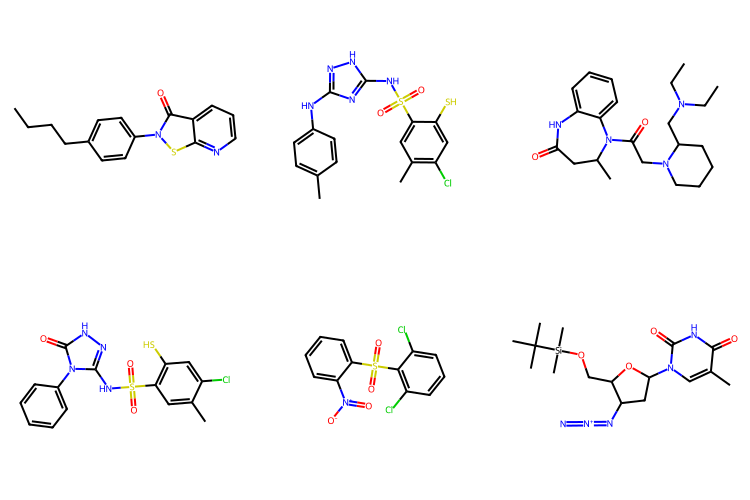

In [103]:
# VAE (ACTIVE)
MolsToGridImage(mols=mols_vae_1, molsPerRow=3, subImgSize=(250, 250), useSVG=True)

In [104]:
mols_cvae_0 = get_mols(df_cvae, 0)
mols_cvae_1 = get_mols(df_cvae, 1)

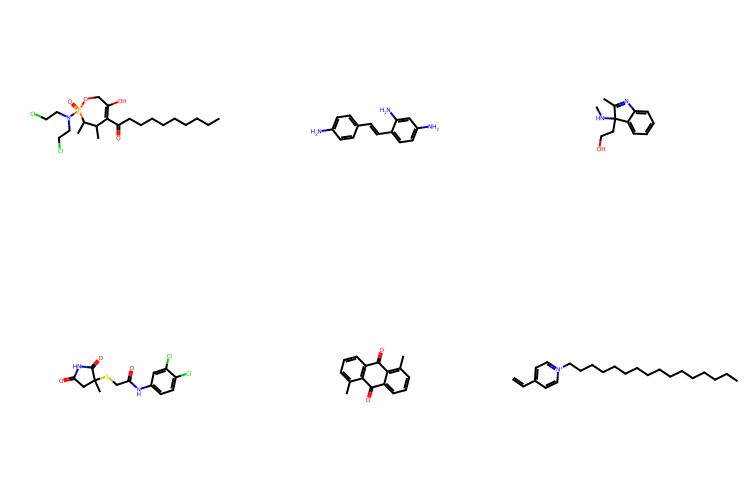

In [105]:
# CVAE (INACTIVE)
MolsToGridImage(mols=mols_cvae_0, molsPerRow=3, subImgSize=(250, 250), useSVG=True)

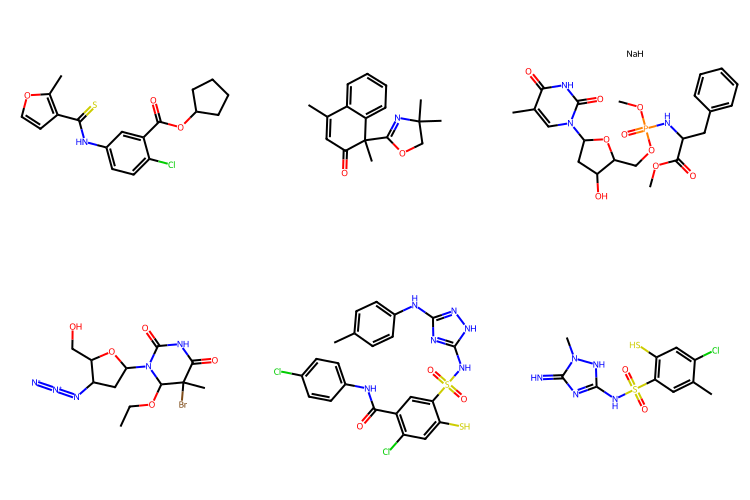

In [106]:
# CVAE (ACTIVE)
MolsToGridImage(mols=mols_cvae_1, molsPerRow=3, subImgSize=(250, 250), useSVG=True)